In [1]:
import matplotlib.pyplot as plt

from PIL import Image
from scipy.misc import imread
from scipy.misc import imsave
import numpy as np
from scipy.stats import multivariate_normal
import math

In [2]:
## Read image
data_path = './Dataset/hw3_img.jpg'
img = Image.open(data_path) # Image object
image = np.array(img) # Array

# get shape
im_w = image.shape[0]
im_h = image.shape[1]

resize_ratio = 0.1
img_resize = img.resize((int(im_h*resize_ratio), int(im_w*resize_ratio))) # Image object
image_resize = np.array(img_resize) # Array

# get shape
im_w_re = image_resize.shape[0]
im_h_re = image_resize.shape[1]

## Normalize pixel value to 0 - 1
im = image/255.0

## Avoid sigular matrix of Cov_mat
bias = 0.0001


# print(im_w,im_h)
# print(im_w_re,im_h_re)
# print(image.shape)
# print(image_resize.shape)

In [3]:
# setting para.
K_cluster = 2
means = np.zeros((K_cluster,3))
for i in range(K_cluster):
    for j in range(3):
        means[i,j] = i
k_ary = np.zeros((im_w_re,im_h_re))

In [4]:
# kmeans
# for k means
# means = np.zeros((1,3,2))
# means[0,:,1]=np.array([1.0, 1.0, 1.0])


def k_means(k_ary, image, means):    
    # init
    init_means = np.zeros_like(means)
    init_cov = np.zeros((K_cluster,3,3))
    init_pi = np.zeros(K_cluster)  
    
    # cal k-array
    for i in range(im_w_re):
        for j in range(im_h_re):
            dist = np.zeros(K_cluster)
            for k in range(K_cluster):
                dist[k] = np.sum((image[i,j,:]-means[k,:])**2)
            k_ary[i,j] = np.argmin(dist)  

    # start update means
    for k in range(K_cluster):
        k_cluster_list = np.where(k_ary == k)
        k_lst_L = len(k_cluster_list[0])
        
        # cal for pi
        init_pi[k] = float(k_lst_L)/float((im_w_re*im_h_re))
        
        # use for create mean 
        if k_lst_L != 0:
            R = image[:,:,0]
            G = image[:,:,1]
            B = image[:,:,2]
            init_means[k,0] = float(R[k_cluster_list].sum())/k_lst_L
            init_means[k,1] = float(G[k_cluster_list].sum())/k_lst_L
            init_means[k,2] = float(B[k_cluster_list].sum())/k_lst_L
            
        # cal Cov.
        N_k = k_lst_L
        val = init_cov[k,:,:]
        
        for i in range(im_w_re):
            for j in range(im_h_re):
                if k_ary[i,j] == k:
                    val += np.dot((image[i,j,:] - init_means[k,:]).reshape((3,1)), (image[i,j,:] - init_means[k,:]).reshape((1,3)))
        init_cov[k,:,:] = val/N_k

    return k_ary, init_means, init_cov, init_pi


IterN = 100
for i in range(IterN):
    k_ary, means, cov, pi = k_means(k_ary, image_resize, means)

print ('======================================')
print ('kmeans - means = \n',means)
print ('kmeans - cov = \n',cov)
print ('kmeans - pi = \n',pi)

# print(means[0,:])
# print(cov[0,:,:])

kmeans - means = 
 [[  79.14459633   46.46732166   12.93720632]
 [ 205.47309219  185.14137627  127.10013233]]
kmeans - cov = 
 [[[ 4114.22834436  1425.91170936   267.15089947]
  [ 1425.91170936  1289.76665959   447.90717483]
  [  267.15089947   447.90717483   447.38990574]]

 [[ 1418.14296807   718.32835199  -110.80431933]
  [  718.32835199  1376.0900701   1290.77344843]
  [ -110.80431933  1290.77344843  4406.7725055 ]]]
kmeans - pi = 
 [ 0.50802951  0.49197049]


In [5]:
print ('======================================')
print ('kmeans - means = \n',means)

kmeans - means = 
 [[  79.14459633   46.46732166   12.93720632]
 [ 205.47309219  185.14137627  127.10013233]]


In [6]:
# for EM algorithm   
likelihood = []
iter_num = 100

def Cal_mean(image, means, gamma_mat):
    new_means = np.zeros((K_cluster,3))   
    
    for k in range(K_cluster):
        r = 0.0
        g = 0.0
        b = 0.0
        N_k = np.sum(gamma_mat[:,:,k])
        for i in range(im_w_re):
            for j in range(im_h_re):
                r += image[i,j,0]*gamma_mat[i,j,k]
                g += image[i,j,1]*gamma_mat[i,j,k]
                b += image[i,j,2]*gamma_mat[i,j,k]
        new_means[k,:] = np.array([r/N_k, g/N_k, b/N_k])
    return new_means

def Cal_cov(image, cov, means, gamma_mat):
    new_cov = np.zeros_like(cov)
    
    for k in range(K_cluster):
        val = new_cov[k,:,:]
        N_k = np.sum(gamma_mat[:,:,k])
        
        for i in range(im_w_re):
            for j in range(im_h_re):
                tmp = np.dot((image[i,j,:] - means[k,:]).reshape((3,1)), (image[i,j,:] - means[k,:]).reshape((1,3)))
                val += gamma_mat[i,j,k]*tmp
        new_cov[k,:,:] = val/N_k
    return new_cov

def Cal_pi(pis,gamma_mat):
    new_pis = np.zeros_like(pis)
    
    for k in range(K_cluster):
        N_k = np.sum(gamma_mat[:,:,k])
        new_pis[k] = N_k/float(im_w_re*im_h_re)
    return new_pis
    
def Cal_gamma(pixel, k, means, cov, pis):
    denom = 0.0
    gamma = 0
    nom = pis[k]*multivariate_normal.pdf(pixel, means[k,:], cov[k,:,:]+bias)
    for i in range(K_cluster):
        denom += pis[i]*multivariate_normal.pdf(pixel, means[i,:], cov[i,:,:]+bias)
    
    gamma = nom/denom
    return gamma

def EM_(image, means, covars, pis, k_array):
    
    # E step
    gamma_mat = np.zeros((im_w_re, im_h_re, K_cluster))
    for i in range(im_w_re):
        for j in range(im_h_re):     
            for k in range(K_cluster):
                gamma_mat[i,j,k] = Cal_gamma(image[i,j,:], k, means, covars, pis)
    
    # M step
    new_means = Cal_mean(image, means, gamma_mat)
    new_covars = Cal_cov(image, covars, new_means, gamma_mat)
    new_pis = Cal_pi(pis, gamma_mat)
    
    return gamma_mat,new_means, new_covars, new_pis

def log_likelihood(image, means, covars, pis):
    val = 0.0
    for i in range(im_w_re):
        for j in range(im_h_re):
            tmp = 0.0
            for k in range(K_cluster):
                # reshape mean to a vector
                mean_vec = means[k,:].reshape(-1)
                tmp += pis[k]*multivariate_normal.pdf(image[i,j,:], mean_vec, covars[k,:,:]+bias)
            val += np.log(tmp)
    return val

print('Start EM Algorithm')
for i in range(iter_num):
    print('iter = ',i)
    
    gamma_mat, means, cov, pi = EM_(image_resize, means, cov, pi, k_ary)
    
    print ('EM - means = \n',means)
    print ('EM - cov = \n',cov)
    print ('EMs - pi = \n',pi)
    print ('=========================================')
    
    likelihood.append(log_likelihood(image_resize, means, cov, pi))
    


Start EM Algorithm
iter =  0
EM - means = 
 [[  82.35009903   45.51720619   11.85555555]
 [ 201.02934645  184.79216996  127.11613709]]
EM - cov = 
 [[[ 4762.78193509  1567.50856434   366.42801175]
  [ 1567.50856434  1234.98758257   400.58209443]
  [  366.42801175   400.58209443   309.28440621]]

 [[ 1727.98961578  1077.65804311   164.58334593]
  [ 1077.65804311  1344.65282006  1217.58051316]
  [  164.58334593  1217.58051316  4381.11493831]]]
EMs - pi = 
 [ 0.50333028  0.49666972]
iter =  1
EM - means = 
 [[  82.0580544    43.17658141   10.69686623]
 [ 197.06118161  182.01623847  124.08608024]]
EM - cov = 
 [[[ 5047.97380244  1597.67658445   392.43878553]
  [ 1597.67658445  1116.51212301   351.11581586]
  [  392.43878553   351.11581586   251.55652619]]

 [[ 1990.48742803  1346.26513353   462.88561578]
  [ 1346.26513353  1519.12642828  1392.00660173]
  [  462.88561578  1392.00660173  4502.95494812]]]
EMs - pi = 
 [ 0.48491459  0.51508541]
iter =  2
EM - means = 
 [[  80.66918199   40.506

 [ 0.35459933  0.64540067]
iter =  17
EM - means = 
 [[  72.24671894   28.44113695    3.61365591]
 [ 179.15318551  161.98134653  105.00906966]]
EM - cov = 
 [[[ 5616.0685885   1281.08070941   139.94640361]
  [ 1281.08070941   446.06518567    53.13740427]
  [  139.94640361    53.13740427    32.1816697 ]]

 [[ 3365.46381348  2689.89220031  1791.26147311]
  [ 2689.89220031  2944.64886385  2637.70697961]
  [ 1791.26147311  2637.70697961  5093.66754524]]]
EMs - pi = 
 [ 0.35412916  0.64587084]
iter =  18
EM - means = 
 [[  72.22988206   28.42050307    3.59790958]
 [ 179.10490104  161.92081523  104.9631524 ]]
EM - cov = 
 [[[ 5617.21711872  1280.83004118   139.5765068 ]
  [ 1280.83004118   445.62295392    52.81510283]
  [  139.5765068     52.81510283    31.91348948]]

 [[ 3370.219588    2694.50882738  1794.54764958]
  [ 2694.50882738  2950.1180044   2641.47670764]
  [ 1794.54764958  2641.47670764  5094.87140031]]]
EMs - pi = 
 [ 0.35378158  0.64621842]
iter =  19
EM - means = 
 [[  72.217033

iter =  33
EM - means = 
 [[  72.17812349   28.36014121    3.55176549]
 [ 178.96514061  161.74389813  104.82899136]]
EM - cov = 
 [[[ 5620.26079473  1280.00507336   138.44069792]
  [ 1280.00507336   444.32954094    51.86728716]
  [  138.44069792    51.86728716    31.13204137]]

 [[ 3383.99314001  2707.85218169  1804.0245497 ]
  [ 2707.85218169  2966.07991153  2652.47527421]
  [ 1804.0245497   2652.47527421  5098.37086716]]]
EMs - pi = 
 [ 0.35276435  0.64723565]
iter =  34
EM - means = 
 [[  72.17794042   28.359933      3.55160637]
 [ 178.96466061  161.74328742  104.82852822]]
EM - cov = 
 [[[ 5620.2708059   1280.00208802   138.43669956]
  [ 1280.00208802   444.32509236    51.86401965]
  [  138.43669956    51.86401965    31.1293633 ]]

 [[ 3384.04042777  2707.89796277  1804.05703756]
  [ 2707.89796277  2966.13496635  2652.51321764]
  [ 1804.05703756  2652.51321764  5098.38293672]]]
EMs - pi = 
 [ 0.35276084  0.64723916]
iter =  35
EM - means = 
 [[  72.17780278   28.35977648    3.55148

EM - means = 
 [[  72.17739342   28.35931104    3.55113103]
 [ 178.96322674  161.74146303  104.82714466]]
EM - cov = 
 [[[ 5620.3007032   1279.99316752   138.42475397]
  [ 1279.99316752   444.31180407    51.85425926]
  [  138.42475397    51.85425926    31.1213642 ]]

 [[ 3384.18168511  2708.03471948  1804.15408485]
  [ 2708.03471948  2966.29943337  2652.6265683 ]
  [ 1804.15408485  2652.6265683   5098.41899389]]]
EMs - pi = 
 [ 0.35275034  0.64724966]
iter =  50
EM - means = 
 [[  72.17739151   28.35930887    3.55112937]
 [ 178.96322174  161.74145667  104.82713983]]
EM - cov = 
 [[[ 5620.30080747  1279.99313639   138.42471229]
  [ 1279.99313639   444.31175772    51.85422522]
  [  138.42471229    51.85422522    31.1213363 ]]

 [[ 3384.18217785  2708.03519652  1804.15442337]
  [ 2708.03519652  2966.30000709  2652.62696371]
  [ 1804.15442337  2652.62696371  5098.41911968]]]
EMs - pi = 
 [ 0.3527503  0.6472497]
iter =  51
EM - means = 
 [[  72.17739008   28.35930724    3.55112812]
 [ 178.9

iter =  66
EM - means = 
 [[  72.17738579   28.35930236    3.5511244 ]
 [ 178.96320674  161.74143759  104.82712536]]
EM - cov = 
 [[[ 5620.30112007  1279.99304309   138.42458736]
  [ 1279.99304309   444.31161876    51.85412315]
  [  138.42458736    51.85412315    31.12125266]]

 [[ 3384.18365508  2708.03662668  1804.15543827]
  [ 2708.03662668  2966.30172711  2652.62814915]
  [ 1804.15543827  2652.62814915  5098.41949678]]]
EMs - pi = 
 [ 0.35275019  0.64724981]
iter =  67
EM - means = 
 [[  72.17738578   28.35930235    3.55112438]
 [ 178.9632067   161.74143754  104.82712532]]
EM - cov = 
 [[[ 5620.30112088  1279.99304284   138.42458703]
  [ 1279.99304284   444.3116184     51.85412288]
  [  138.42458703    51.85412288    31.12125244]]

 [[ 3384.18365894  2708.03663042  1804.15544092]
  [ 2708.03663042  2966.3017316   2652.62815225]
  [ 1804.15544092  2652.62815225  5098.41949776]]]
EMs - pi = 
 [ 0.35275019  0.64724981]
iter =  68
EM - means = 
 [[  72.17738577   28.35930233    3.55112

EMs - pi = 
 [ 0.35275019  0.64724981]
iter =  83
EM - means = 
 [[  72.17738573   28.3593023     3.55112434]
 [ 178.96320658  161.74143739  104.82712521]]
EM - cov = 
 [[[ 5620.30112333  1279.99304211   138.42458605]
  [ 1279.99304211   444.31161731    51.85412208]
  [  138.42458605    51.85412208    31.12125178]]

 [[ 3384.18367052  2708.03664162  1804.15544887]
  [ 2708.03664162  2966.30174508  2652.62816154]
  [ 1804.15544887  2652.62816154  5098.41950072]]]
EMs - pi = 
 [ 0.35275019  0.64724981]
iter =  84
EM - means = 
 [[  72.17738573   28.3593023     3.55112434]
 [ 178.96320658  161.74143739  104.82712521]]
EM - cov = 
 [[[ 5620.30112334  1279.99304211   138.42458605]
  [ 1279.99304211   444.3116173     51.85412208]
  [  138.42458605    51.85412208    31.12125178]]

 [[ 3384.18367055  2708.03664165  1804.15544889]
  [ 2708.03664165  2966.30174512  2652.62816156]
  [ 1804.15544889  2652.62816156  5098.41950073]]]
EMs - pi = 
 [ 0.35275019  0.64724981]
iter =  85
EM - means = 
 [

EM - means = 
 [[  72.17738573   28.3593023     3.55112434]
 [ 178.96320658  161.74143739  104.82712521]]
EM - cov = 
 [[[ 5620.30112336  1279.9930421    138.42458604]
  [ 1279.9930421    444.3116173     51.85412207]
  [  138.42458604    51.85412207    31.12125178]]

 [[ 3384.18367064  2708.03664174  1804.15544895]
  [ 2708.03664174  2966.30174522  2652.62816163]
  [ 1804.15544895  2652.62816163  5098.41950075]]]
EMs - pi = 
 [ 0.35275019  0.64724981]


In [7]:
print(means)

[[  72.17738573   28.3593023     3.55112434]
 [ 178.96320658  161.74143739  104.82712521]]


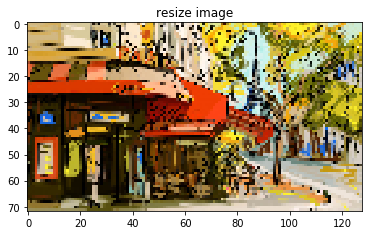

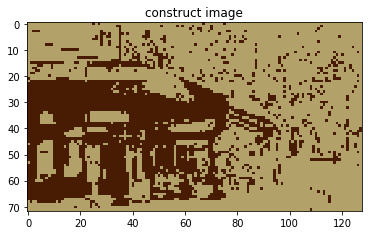

In [12]:
# reconstruct image
def construct_image(image, means, gamma_matrixs):
    k_num = gamma_matrixs.shape[2]
    new_image = np.zeros_like(image)
    for i in range(im_w_re):
        for j in range(im_h_re):
            compare_ls = []
            for k in range(k_num):
                compare_ls.append(gamma_matrixs[i,j,k])
            min_idx = np.argmax(compare_ls)
            new_image[i,j,0] = means[min_idx,0]
            new_image[i,j,1] = means[min_idx,1]
            new_image[i,j,2] = means[min_idx,2]
    return new_image

new_image = construct_image(image_resize, means, gamma_mat)    

# plot log likelihood & image
# plt.figure()
# plt.plot(range(len(likelihood)),likelihood, 'r')
# plt.title('log likelihood')

plt.figure()
plt.imshow(image_resize)
plt.title('resize image')

plt.figure()
plt.imshow(new_image)
plt.title('construct image')

# save fig
plt.savefig('./K_%s_reconstructImg.png'%str(K_cluster))

plt.show()

In [9]:
# print(new_pis)
#now [0.51673384  0.48326616]

In [10]:
# print(np.array([[1,2,3],[1,2,3]]).sum())

In [11]:
# export to python file
#!jupyter nbconvert --to python Problem3_Gaussian_Mixture_Model.ipynb